# Musk molecules classification

1. Problem definition and description of dataset

This report is dedicated to solution of musk molecules classification problem. This is the original description of the problem and provided dataset:
This dataset describes a set of 102 molecules of which 39 are judged by human experts to be musks and the remaining 63 molecules are judged to be non-musks.  The goal is to learn to predict whether new molecules will be musks or non-musks.  However, the 166 features that describe these molecules depend upon the exact shape, or conformation, of the molecule.  Because bonds can rotate, a single molecule can adopt many different shapes.  To generate this data set, all the low-energy conformations of the molecules were generated to produce 6,598 conformations.  Then, a feature vector was extracted that describes each conformation.

This many-to-one relationship between feature vectors and molecules is called the "multiple instance problem".  When learning a classifier for this data, the classifier should classify a molecule as "musk" if ANY of its conformations is classified as a musk.  A molecule should be classified as "non-musk" if NONE of its conformations is classified as a musk.

The features are "distance features" along rays (see original paper).  The distances are measured in hundredths of Angstroms.  The distances may be negative or positive, since they are actually measured relative to an origin placed along each ray.  The origin was defined by a "consensus musk" surface that is no longer used.  Hence, any experiments with the data should treat these feature values as lying on an arbitrary continuous scale.  In particular, the algorithm should not make any use of the zero point or the sign of each feature value.

2. Problem analysis.

Before we apply any kind of machine learning algorithms let's carefully analyse what can we expect. The task is not trivial - we do not have classical data point plus label dataset. Instead, it is clearly said that each chemical formula can be realized in many different physical conformations and thus demonstrate different properties. The labels are the same for conformations of same molecules, but it is critical to notice, that it is expected to have unclear classification for musk molecules - it is enough to have "ANY of its conformations is classified as a musk". While non-musk molecules are stricter - it is known that none of its conformations can be misclassified.

Practically, future molecules will be converted to their sets of conformations, those will be measured and the algorithm will see all these conformations to define, whether any of them can be classified as musk based on their features values. This will work if feature space can be split in regions by classification "musk or not" and we can learn this split.

Normally, we expect that dataset represents this split, i.e. if a point is labeled as musk we expect that some neighbour around this point in feature space belongs to "musk" region. The problem is - the given dataset DOES NOT FOLLOW this "locality" rule - points are classified by whether OTHER conformations of the same molecule are in "true" musk region. If any - the whole group is classified as musk.

Machine learning algorithms follow "locality" rule by construction - they cannot learn exotic space splitting where in any arbitrary small neighbor ϵ of a point P of class 1 there is always at least one point of class 0. Thus, our first fundamental assumption (and at the same time requirement to those, who construct the features) is:

* features space can be split "good enough" to musk/non-musk regions to be learned by machine learning algorithms

 And by "good enough" we mean first of all "locality" characteristic. We can estimate it as the biggest radius of a sphere around a point which will not contain points of another class. We can think of it as size of domains in feature space. If the split is as random as a QR-Code, the chances to learn it and then use in practice are almost zero. Ideally, we want the boundaries between regions be "good enough" as well. ML algorithms can learn boundaries only of "finite complexity", i.e. they can be weird, but not infinetely like fractals. Practically, difference between true boundary and a learned one will contribute to classification error.

 Now the main question: is it possible to learn an underlying true space split by the given data? Again, our data are "misclassified" from the beginning - labels do not correspond to features point by point. Well, not exactly - it is known that non-musk molecules conformations are all in true "negative" regions. We can use this fact to construct the following high-level algorithm:
 * we start with all data points classified as musk and assume that feature space they cover belongs to true positive region(s)
 * we continue with non-musk data points and define space region(s) they cover and label it as true negative
 * if positive and negative regions intersect, we assume intersection to be true negative as we sure that negative examples are always true negative
 * if there are remained positive regions, we assume they are true positive as there is no reason to assume the opposite

 The worst what can happen is that there will be no true positive regions after intersection with negative ones. It is technically possible by 3 reasons:

 * we have calculated the boundaries of regions not accurate enough
 * the dataset does not contain enough data to accurately define true boundaries
 * our "locality" assumption does not hold - the problem is unsolvable at least in this features space

 Second, we cannot say anything about points which do not belong neither positive nor negative examples from the dataset. Like in any other ML problem extrapolation is always more risky than interpolation. It would be a miracle if we see a single-surface separation of feature space to 2 clear regions so we can conclude - this is it. Normally, points far away from training ones should be processed with big care.  Depending on ML algorithm we use it is also possible that there will be "unclassified" regions between positive and negative ones like "holes" in feature space.

 We can say, that an algorithm is successfull, if at the end there are true positive regions and at least one data point of ALL musk-labeled molecules lies in one of those regions.



3. Solution plan

Our analysis shows that we are going to rely on metric properties of our dataset. All features are numerical (and integers, although their physical meaning supppose real values). This makes it easier to define metrics - we assume the feature space to be Euclidean with 166 dimensions.

We will have to center and rescale each feature as we heavily rely on distances between data points.

We also must check for even distribution of points along each feature - no long tails as they will dramatically affect boundaries calculations.

We will start with kNN algorithm to check, how well in general positive and negative points are separated. If we see no or very little misclassifications, then we can conclude that conformations regions represent "true" regions and we can just use the dataset as is either with conjunction with kNN algorithm as the final solution or building another ML model to speed-up classification by learning region boundaries.

If kNN shows significant misclassification, it means that data points are mixed in feature space. In this case we can apply  described above workflow to re-label those positive points which happen to be inside negative regions by using 1-step kNN with voting - if majority of k nearest neighbours are negetive - the point is relabeled as negative. If after such relabeling there are at least 1 data point left for all positively labeled molecules, we can use this dataset either with kNN or other ML algorithm which will learn boundaries. If not - we will have to apply more advanced techniques to try to better define shapes of regions defined by dataset: topological analysis or clustering.

4. Dataset analysis and preparation

First, we have a look at statistics of raw data:

In [54]:
# @title
import pandas as pd

data = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/data/musk2.csv.txt', sep=',')
stat_data = data.drop(['ID', 'class'], axis=1).describe().T
stat_data['z-score'] = (stat_data['max'] -stat_data['mean'])/(stat_data['std'])
stat_data.sort_values(by='z-score', ascending=False)

,count,mean,std,min,25%,50%,75%,max,z-score
f76,6598.0,-175.827372,13.975250,-195.0,-182.0,-180.0,-176.0,21.0,14.083996
f147,6598.0,-113.114580,21.463582,-136.0,-121.0,-119.0,-115.0,172.0,13.283644
f67,6598.0,-155.735677,48.084476,-167.0,-166.0,-166.0,-165.0,234.0,8.105229
f163,6598.0,201.760230,59.526751,73.0,166.0,191.0,215.0,625.0,7.110077
f145,6598.0,-165.748863,54.087579,-179.0,-178.0,-178.0,-178.0,213.0,7.002511
...,...,...,...,...,...,...,...,...,...
f90,6598.0,30.591846,123.957652,-157.0,-117.0,81.0,134.0,269.0,1.923303
f119,6598.0,-17.505305,120.421611,-196.0,-168.0,8.0,84.0,209.0,1.880936
f64,6598.0,-17.274022,131.326710,-195.0,-175.0,-3.0,109.0,225.0,1.844819
f118,6598.0,-42.358745,110.701484,-212.0,-176.0,14.0,38.0,156.0,1.791835


Classes balance:

In [55]:
# @title
data['class'].value_counts()

,count
class,
0,5581
1,1017


As we see there are some features with signifiant skew - we should apply preprocessing to normalize and unskew the features. Classes balance also does not look good - we have 5:1 ratio to non-musk classified conformations and we expect the ratio even less if we need to relabel points. It is not a problem for kNN algorithm but for any other to learn boundaries.

5. kNN classification

As discussed above, we first apply kNN algorithm to define how good data points are separated in feature space. We want to approve labels consistency for EVERY point in the dataset. This is so-called leave-one-out cross-validation - when we use only one point as test but every point. We use error matrix to see the number of misclassified points for each class.

In [70]:
# @title
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut, cross_val_predict
from sklearn import metrics

feature_cols = data.columns[3:-1]


X=data.loc[:, feature_cols]
y=data.loc[:, 'class']

pt = PowerTransformer(method='yeo-johnson', standardize=True)
X_trf = pt.fit_transform(X)
mod = KNeighborsClassifier(n_neighbors=11)
mod.fit(X, y)
#loo = LeaveOneOut()
#Y = cross_val_predict(mod, X_trf, y, cv=loo)

distances, indices = mod.kneighbors(X)
# Drop the first neighbor (the point itself) -> keep next k neighbors
neighbor_indices = indices[:, 1:11]

predicted_labels = []
n_of_other_classes = []
for i in range(len(X)):
    neighbor_labels = y[neighbor_indices[i]]
    # majority vote
    counts = np.bincount(neighbor_labels)
    predicted_labels.append(np.argmax(counts))
    #own class
    own_class = y[i]
    n_of_other_clas = sum([1 for i in neighbor_labels if i != own_class])
    n_of_other_classes.append(n_of_other_clas)


Y = np.array(predicted_labels)

print("Recall: %f\n" % metrics.recall_score(Y, y))

confusion_matrix = metrics.confusion_matrix(Y, y)
print("Confusion Matrix: ")
print(confusion_matrix)
print()


Recall: 0.955504

Confusion Matrix: 
[[5543  201]
 [  38  816]]



Looks very promising. Using 10 nearest neighbors we achieve recall of 95% - very good result for a problem with such unclear formulation. Let's check the distribution of number of points with different class around each point. This will allow us to see how mixed the datapoints are.

In [76]:
N = pd.DataFrame({'n_of_other_class': n_of_other_classes})
#N['n_of_other_class'].plot.hist()
N['n_of_other_class'].value_counts()

,count
n_of_other_class,
0,4227
1,1184
2,506
3,284
4,106
5,81
7,63
8,51
6,48


As we see, there are 5411 points with at maximum 1 point of other class in its neighbor. On anothre side, there are 99 points with at least 8 other class points around. This proportion is not significant, it may signal the outliers or very slight intersection of domains. Also important to note that the number of "ambiguos" points with 4-6 "aliens" in their neighbor is just 235 what indicates that there is no significant mix in classes points.

Technically, we can accept this dataset as a base to kNN algorithm for future classifications. Yet it would be interesting to see what boundaries learning algorithms will show us.

6. Decision tree classification

From all algorithms which learn boundaries between classes decision tree algorithm has the most interpretability. Though we do not expect the same high performance as class boundaries will be axes-alligned in this case, we will use it to see what features play crutial role in musk/non-musk separation.

In [57]:
# @title
from sklearn.tree import DecisionTreeClassifier

mod = DecisionTreeClassifier()
steps = [('transform', pt), ('model', mod)] # DecisionTree does not need feature transformation, but we use this universal code snippet
pipe = Pipeline(steps=steps)
param_grid = {'model__max_depth': list(range(1, 20))}
scorer = metrics.make_scorer(metrics.recall_score, average='macro')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1
)
grid_search.fit(X, y)
print("Best max_depth:", grid_search.best_params_['model__max_depth'])
print("Best average recall (CV):", grid_search.best_score_)

Best max_depth: 17
Best average recall (CV): 0.9313192278277928


K-fold cross validation can achieve almost the same recall as leave-one-out kNN with relatively deep tree - 17 levels. Let's visualize them to see the complexity:

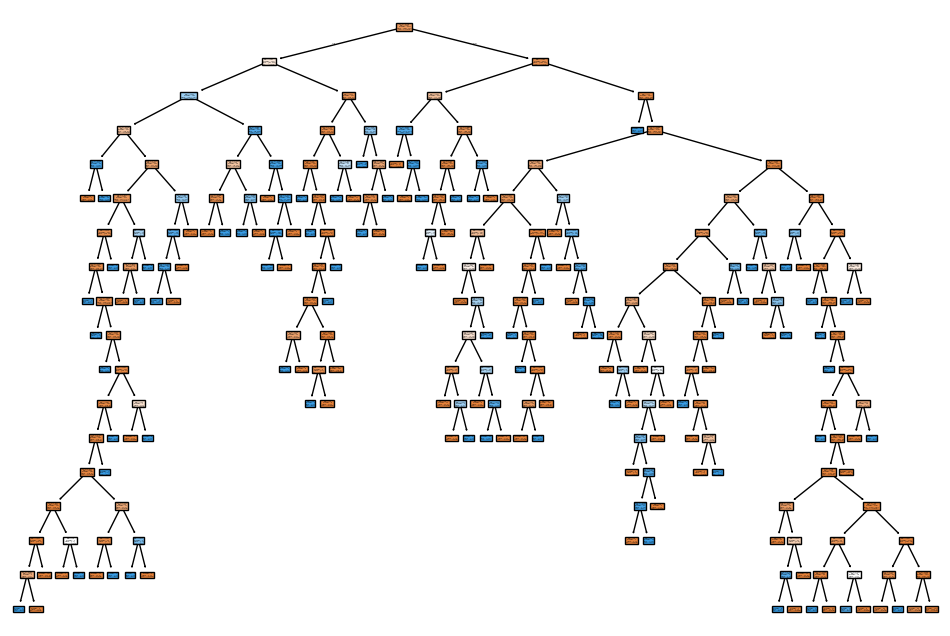

In [58]:
# @title
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plot_tree(grid_search.best_estimator_['model'], feature_names=feature_cols, class_names=['non-musk', 'musk'], filled=True)
plt.show()

In [59]:
# @title
def export_text_with_class_counts(tree, feature_names=None, class_names=None, max_depth=None):
    def recurse(node, depth=0):
        indent = "  " * depth
        n_samples = tree.n_node_samples[node]
        proportions = tree.value[node]
        values = proportions * n_samples  # class counts at this node
        if max_depth is not None and depth >= max_depth:
            print(f"{indent}... (max depth reached)")
            return
        if tree.children_left[node] == -1:
            # Leaf node
            class_counts_str = ", ".join(f"{class_names[i]}: {int(v)}"
                                         for i, v in enumerate(values[0]))
            print(f"{indent}Leaf node: samples={n_samples}, class_counts=[{class_counts_str}]")
        else:
            # Split node
            feature = feature_names[tree.feature[node]]
            threshold = tree.threshold[node]
            class_counts_str = ", ".join(f"{class_names[i]}: {int(v)}" for i, v in enumerate(values[0]))
            print(f"{indent}{feature} <= {threshold:.3f}, samples={n_samples}, class_counts=[{class_counts_str}]")
            recurse(tree.children_left[node], depth + 1)
            recurse(tree.children_right[node], depth + 1)
    recurse(0)

export_text_with_class_counts(grid_search.best_estimator_['model'].tree_, feature_names=feature_cols, class_names=['non-musk', 'musk'], max_depth=4)

f36 <= -0.718, samples=6598, class_counts=[non-musk: 5581, musk: 1017]
  f124 <= 0.586, samples=1235, class_counts=[non-musk: 681, musk: 554]
    f9 <= 0.423, samples=738, class_counts=[non-musk: 244, musk: 493]
      f32 <= -0.619, samples=297, class_counts=[non-musk: 200, musk: 97]
        ... (max depth reached)
        ... (max depth reached)
      f55 <= -1.969, samples=441, class_counts=[non-musk: 45, musk: 396]
        ... (max depth reached)
        ... (max depth reached)
    f140 <= 0.528, samples=497, class_counts=[non-musk: 436, musk: 61]
      f151 <= 1.997, samples=449, class_counts=[non-musk: 422, musk: 27]
        ... (max depth reached)
        ... (max depth reached)
      f66 <= -1.150, samples=48, class_counts=[non-musk: 14, musk: 34]
        ... (max depth reached)
        ... (max depth reached)
  f132 <= -1.042, samples=5363, class_counts=[non-musk: 4900, musk: 463]
    f66 <= 0.156, samples=553, class_counts=[non-musk: 371, musk: 182]
      f17 <= -0.421, sample

It looks like there is no clear boundary that can be found by decision tree which could split vast amount of samples. Short branches "cut off" relatively small amount of samples from the main bunch. Non-axis-alligned splits, like generic hyperplanes could probably provide better results but they are difficult to interpret. The textual structure presented above shows top 4 levels of the tree and will be addressed to data provoder for review.

7. SVM algorithm

Decision tree and methods based on it (random forest, boosting on trees, non-axis-alligned splits) can learn very complex boundaries. Basically, only when the fundamental assumption of locality breaks (or data contain a lot of outliers) such algorithms will perform poorly. If features domains have well-defined boundaries, those algorithms will find them.

Countrary, SVM algorithm even with the kernel trick is biased to smooth boundaries, though the most powerfull kernel - RBF - can recognize even multi-modal distributions. Let's train SVM with RBF and choose hyper-parameters based on grid search.

In [62]:
from sklearn.svm import SVC

mod = SVC(kernel='rbf', class_weight='balanced')
steps = [('transform', pt), ('model', mod)]
pipe = Pipeline(steps=steps)

C_range = np.logspace(-2, 2, 5)
gamma_range = np.logspace(-4, 0, 5)
param_grid = {'model__gamma': gamma_range, 'model__C': C_range}

scorer = metrics.make_scorer(metrics.recall_score, average='macro')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1
)
grid_search.fit(X, y)
print("Best gamma:", grid_search.best_params_['model__gamma'])
print("Best C:", grid_search.best_params_['model__C'])
print("Best average recall (CV):", grid_search.best_score_)

Best gamma: 0.001
Best C: 100.0
Best average recall (CV): 0.9945398826447531


That's spooky. But technically possible. Just a "brute-force" kNN has showed already 95% of correct classifications. The rest 6% are either in "touch" or "deep intersection" regions of domains. If there is only a touch and domains are separable - SVM finds the separation surface and thus increase the classification performance.

8. Conclusion and future works

Presented dataset has a bit specific nature. It is syntetic dataset constructed from mathematical computations of molecules forlulas. The formulas themselves are somehow "valid" objects, so the whole dataset represents a space of values which can take certain function defined on a well-structured set. This alone gives a lot of hope that further mathematics will be also successfull or at least trustable. Unlike most of datasets in ML this one does not contain errors of measurements, errors in labeling and underlying process of generating data does not introduce significant disturbance to overall structure. Yet the final goal is indeed a very high-level characteristic of a substance - is it musk or not. May be it is a luck that ML can learn this implicit connection between formula and physical characteristic (there are much more examples when it is not that successfull, especially in biology), but the winner takes it all.

As future steps it would be highly beneficial to investigate geometry of dataset and decision boundaries:
* do data demonstrate clear cluster structure?
* what are their parameters and in what regions are they?
* is decision boundary smooth or complex?
* are there unoccupued areas in feature space and what could pass there?